In [1]:
import pandas as pd
import numpy as np
#from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix,recall_score
from matplotlib.legend_handler import HandlerLine2D

from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [193]:
org=pd.read_csv('D:/Desktop/Flex 3/Titanic Kaggle/titanic/train.csv')

In [3]:
org.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
org.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [42]:
#pclass: A proxy for socio-economic status (SES)
#1st = Upper
#2nd = Middle
#3rd = Lower


# SibSp = # of siblings / spouses aboard the Titanic

#parch = # of parents / children aboard the Titanic

#org['Ticket'].unique()

In [5]:
org.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
def missing_data(df):
    miss_summary = pd.DataFrame(columns=['variable','missing_count', 'missing_%'])
    columns = df.columns
    for col in columns:
        col_name = col
        count = df[col].isnull().sum()
        percentage = round((df[col].isnull().sum()/df[col].shape[0])*100,2)
        miss_summary.loc[len(miss_summary)] = [col_name, count, percentage]
        miss_summary.sort_values('missing_count',ascending=False,inplace=True)
    print(miss_summary)

In [8]:
missing_data(org)

       variable missing_count  missing_%
10        Cabin           687      77.10
5           Age           177      19.87
11     Embarked             2       0.22
0   PassengerId             0       0.00
1      Survived             0       0.00
2        Pclass             0       0.00
3          Name             0       0.00
4           Sex             0       0.00
6         SibSp             0       0.00
7         Parch             0       0.00
8        Ticket             0       0.00
9          Fare             0       0.00


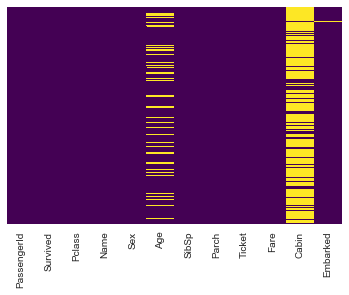

In [138]:
sns.heatmap(org.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [116]:
org.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int32
Fare        float64
Embarked     object
dtype: object

In [14]:
org['Parch']=org.Parch.astype('int')

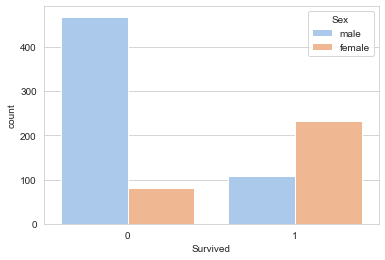

In [74]:
#count-plot of people survided 
sns.set_style('whitegrid');
sns.countplot(x='Survived', hue='Sex', data=org, palette='pastel');

__Women were almost twice as likely to survive than men.__

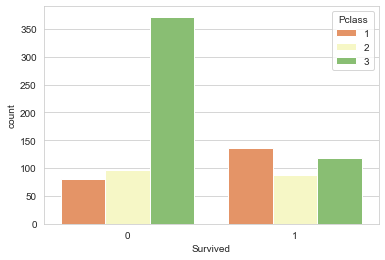

In [73]:
#no. of people who survived according to their Passenger Class
sns.set_style('whitegrid')
sns.countplot(x='Survived', hue='Pclass', data=org, palette='RdYlGn');

__Class 3 has lower probability of survival as opposed to Class 1__

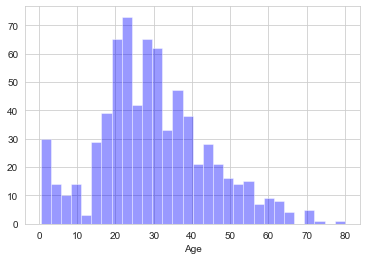

In [80]:
#distribution plot of age of the people
sns.distplot(org['Age'], kde=False, bins=30, color='Blue');

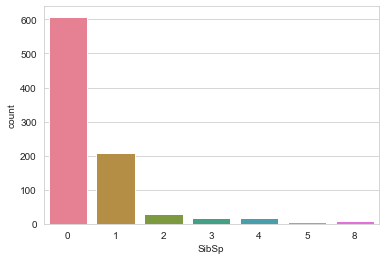

In [77]:
#countplot of the people having siblings or spouce
sns.countplot(x='SibSp',data=org,palette='husl');

__Most of the people on board did not have any children, parents or spouse.__

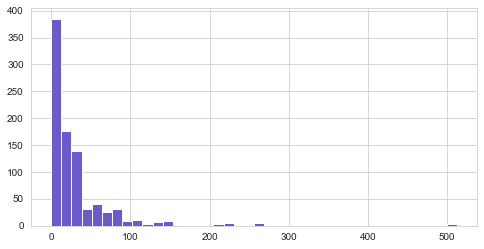

In [83]:
#distribution plot of the ticket fare
org['Fare'].hist(color='slateblue',bins=40,figsize=(8,4));

 __Most of the passengers have bought cheaper tickets as purchase prices are between 0 and 50.__

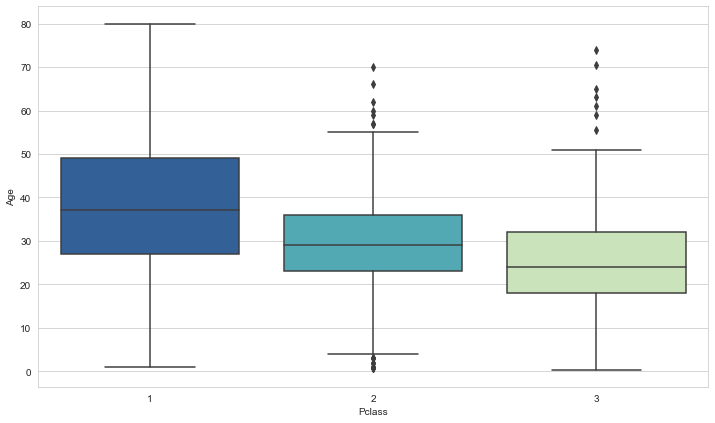

In [103]:
#boxplot with age on y-axis and Passenger class on x-axis.
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=org,palette='YlGnBu_r')

__Wealthier people have higher age. Hence, we replace the missing age with mean of the respective classes.__

In [194]:
#77% missing data in Cabin. Hence dropping it from analysis.
#Dropping Name and Passenger ID from further analysis.
#Name can be possibly used to identify the relation between people on board.
org.drop(['Cabin','PassengerId','Name','Ticket'],1,inplace=True)

In [195]:
#Checking mode of Embarked to ensure NaN is not the mode
print(org.Embarked.mode(dropna=False))
#Mode = S. Hence, fillna= mode
org.Embarked.fillna(org.Embarked.mode()[0], inplace=True)
#org.Age.fillna(org.Age.mean(), inplace=True)

org['Age'] = org['Age'].fillna(org.groupby('Pclass')['Age'].transform('mean'))
org.head(10)

0    S
dtype: object


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.00000,1,0,7.2500,S
1,1,1,female,38.00000,1,0,71.2833,C
2,1,3,female,26.00000,0,0,7.9250,S
3,1,1,female,35.00000,1,0,53.1000,S
4,0,3,male,35.00000,0,0,8.0500,S
5,0,3,male,25.14062,0,0,8.4583,Q
6,0,1,male,54.00000,0,0,51.8625,S
7,0,3,male,2.00000,3,1,21.0750,S
8,1,3,female,27.00000,0,2,11.1333,S
9,1,2,female,14.00000,1,0,30.0708,C


In [244]:
org.shape

(891, 8)

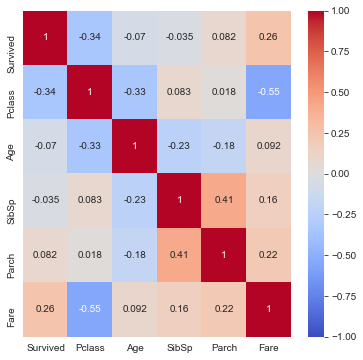

In [86]:
fig=plt.subplots(figsize=(6,6))
sns.heatmap(org.corr(), annot = True, vmin=-1, vmax=1,center= 0, cmap= 'coolwarm');
#Fare and Pclass have a fairly high correlation.

In [153]:
org.Parch.unique()

array([0, 1, 2, 5, 3, 4, 6], dtype=int64)

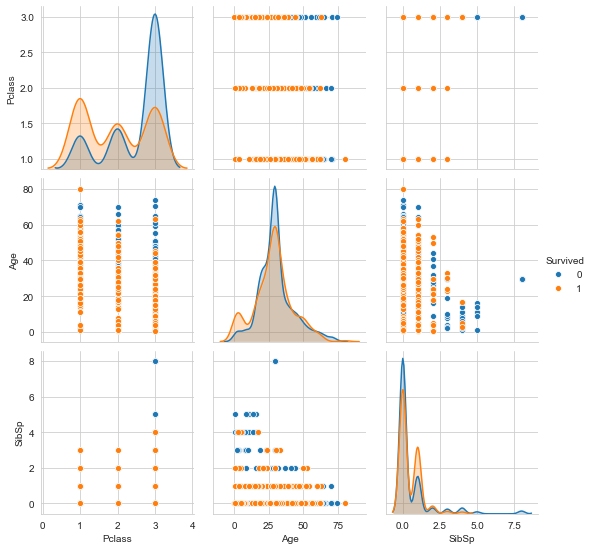

In [88]:
#sns.distplot(org['Age'])
sns.pairplot(org[['Survived', 'Pclass', 'Age', 'SibSp','Sex','Embarked']],hue='Survived');

In [154]:
df=pd.get_dummies(org,prefix_sep='_')
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


In [57]:
#Sex=org.Sex.values
#org.Sex=LabelBinarizer().fit_transform(org.Sex.values)
#org.Embarked=LabelEncoder().fit_transform(org.loc[:,'Embarked'])
#org.Embarked=LabelBinarizer().fit_transform(org.Embarked.values)

In [32]:
df.dtypes

Survived        int64
Pclass          int64
Age           float64
SibSp           int64
Parch           int32
Fare          float64
Sex_female      uint8
Sex_male        uint8
Embarked_C      uint8
Embarked_Q      uint8
Embarked_S      uint8
dtype: object

In [275]:
#Pair plot is a bad idea!

#fig,ax=plt.subplots(figsize=(15,15))
#sns.pairplot(df,hue="Survived")
#plt.show()
X=df.drop('Survived',axis=1)
y=df.Survived

### Reading and cleaning of test files

In [113]:
X_test=pd.read_csv('D:/Desktop/Flex 3/Titanic Kaggle/titanic/test.csv')
X_test.drop(['Cabin','PassengerId','Name','Ticket'],1,inplace=True)
print(missing_data(X_test))

   variable missing_count  missing_%
2       Age            86      20.57
5      Fare             1       0.24
0    Pclass             0       0.00
1       Sex             0       0.00
3     SibSp             0       0.00
4     Parch             0       0.00
6  Embarked             0       0.00
None


In [114]:
X_test.Embarked.fillna(X_test.Embarked.mode()[0], inplace=True)
X_test.Age.fillna(X_test.Age.mean(), inplace=True)
X_test.Fare.fillna(X_test.Fare.mean(), inplace=True)

#### Split the training data for insample testing in 80:20 ratio

In [276]:
X_train, insample_X_test, y_train, insample_y_test = train_test_split(X,y, test_size=0.2,random_state=100)

In [53]:
print(df.shape)
print(X_train.shape)

(891, 11)
(712, 10)


### Build a Decision Tree Classifier

In [54]:
tree=DecisionTreeClassifier(random_state=10)
clf=tree.fit(X_train,y_train)

clf

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=10, splitter='best')

In [55]:
y_pred=tree.predict(insample_X_test)

In [56]:
print(accuracy_score(insample_y_test,y_pred))

false_positive_rate, true_positive_rate, thresholds = roc_curve(insample_y_test, y_pred)

roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

#Get recall score
print(recall_score(insample_y_test, y_pred))

0.776536312849162
0.7686538461538461
0.72


In [45]:
#!pip install pydotplus

Processing c:\users\pooja\appdata\local\pip\cache\wheels\35\7b\ab\66fb7b2ac1f6df87475b09dc48e707b6e0de80a6d8444e3628\pydotplus-2.0.2-cp37-none-any.whl


In [57]:
import pydotplus
from IPython.display import Image
from sklearn import tree

dot_data=tree.export_graphviz(clf,out_file=None,feature_names=list(X_train.columns.values),label='all',rounded=True,filled=True,impurity=True,class_names=['0','1'])
graph=pydotplus.graph_from_dot_data(dot_data)

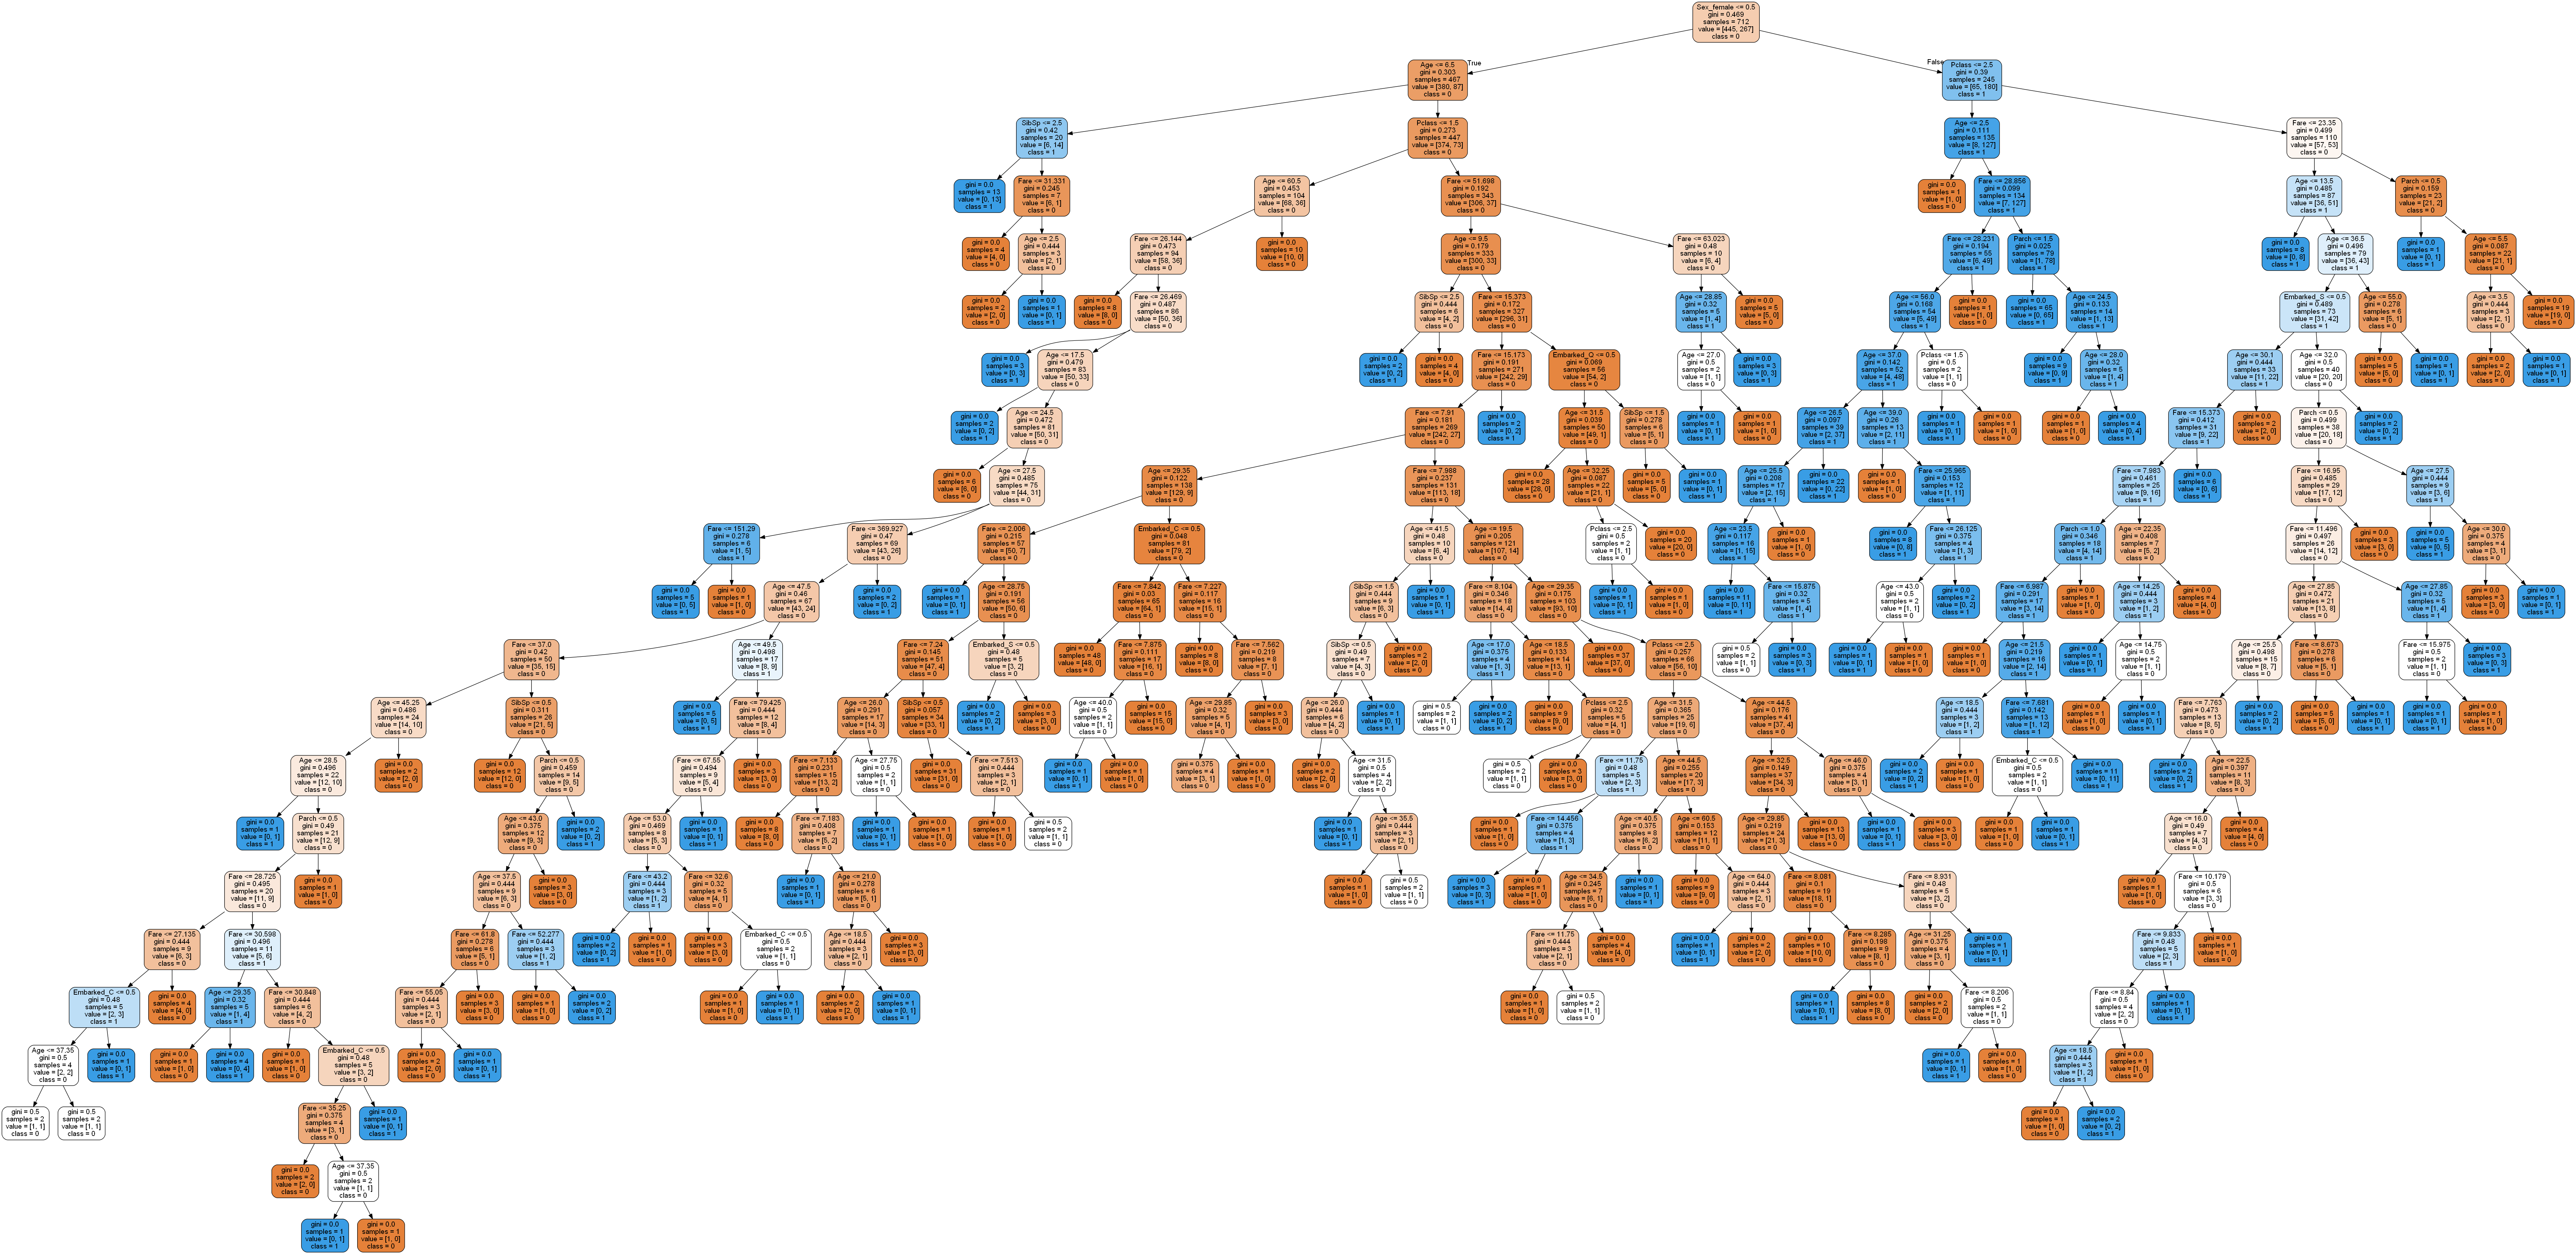

In [58]:
Image(graph.create_png())

### Hyperparameter tuning of Decision Tree
- max_depth (default = None): split until all leaves are pure or until all leaves contain less than min_samples_split samples.
- min_samples_split (default = 2): number of samples required to split an internal node 

- min_samples_leaf (default = 1): (leaf refers to node without any children)split only if if it leaves at least min_samples_leaf training samples in both left and right branches. Ignore for low observations. Use low number for imbalanced class.

- max_features (default = None; all features): use options: sqrt, log2

- random_state (default = None): splitter introduces some randomness. Hence, set a value to get consistent results

- min_impurity_decrease (default=0) :A node will be split if it results in a decrease of the impurity greater than or equal to this value

- class_weight (default = None): Useful for an imbalanced dataset. Resulting child nodes are weighted by the class_weight while calculation of entropy. This is not undersampling or oversampling. Number of samples in a class doesn’t change, its assigned weight changes to : weight * (the number of samples from a class in the node) / (size of class)
- ccp_alpha: complexity parameter to prune the tree. Greater the value of alpha, more is the impurity at each node and lesser is the node count

##### max_depth, min_samples_split, and min_samples_leaf are stopping criterias
##### min_weight_fraction_leaf and min_impurity_decrease are pruning methods.

##### Difference between min_smaples_split and min_samples_leaf:
Say you specify a min_samples_split and the resulting split results in a leaf with 1 sample and you have specified min_samples_leaf as 2, then your min_samples_split will not be allowed.
In other words, min_samples_leaf is always guaranteed no matter the min_samples_split value.

### Detemine the optimum value of hyperparameter: max_depth

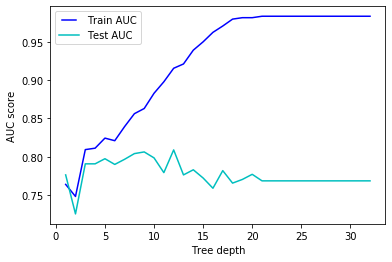

In [59]:
depths = np.linspace(1, 32, 32)
train_results = []
test_results = []

for i in depths:
   tree = DecisionTreeClassifier(max_depth=i,random_state=10)
   tree.fit(X_train, y_train)
   train_pred = tree.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = tree.predict(insample_X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(insample_y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(depths, train_results,color='b', label='Train AUC')
line2, = plt.plot(depths, test_results,color='c', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

In [60]:
int(depths[test_results.index(max(test_results))])

12

#### As seen from the plot above, maximum AUC is obtained using max_depth=12

### Detemine the optimum value of  hyperparameter: min_samples_split

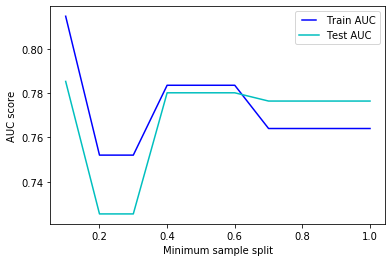

In [61]:
splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []

for i in splits:
   tree = DecisionTreeClassifier(min_samples_split=i,random_state=10)
   tree.fit(X_train, y_train)
   train_pred = tree.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = tree.predict(insample_X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(insample_y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(splits, train_results,color='b', label='Train AUC')
line2, = plt.plot(splits, test_results,color='c', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Minimum sample split')
plt.show()

In [62]:
splits[test_results.index(max(test_results))]

0.1

#### As seen from the plot above, maximum AUC is obtained using min_samples_split = 0.1.
Also, the AUC score at 0.4 is close for insample test data and train data.

### Detemine the optimum value of  hyperparameter: max_features

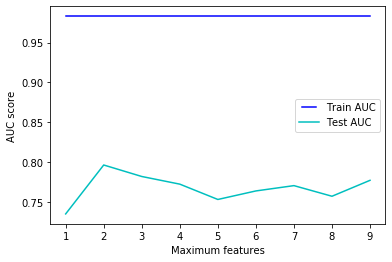

In [63]:
features= list(range(1,X_train.shape[1]))
train_results = []
test_results = []

for i in features:
   tree = DecisionTreeClassifier(max_features=i,random_state=10)
   tree.fit(X_train, y_train)
   train_pred = tree.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = tree.predict(insample_X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(insample_y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(features, train_results,color='b', label='Train AUC')
line2, = plt.plot(features, test_results,color='c', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Maximum features')
plt.show()

#### For all values of max_features, the model overfits. By default, model inspects all features to find an optimum split.

### Detemine the optimum value of  hyperparameter: min_samples_leaf

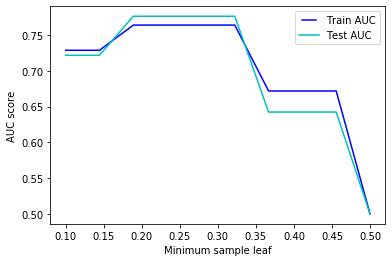

In [64]:
leafs = np.linspace(0.1, 0.5, 10, endpoint=True)
train_results = []
test_results = []

for i in leafs:
   tree = DecisionTreeClassifier(min_samples_leaf=i,random_state=10)
   tree.fit(X_train, y_train)
   train_pred = tree.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = tree.predict(insample_X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(insample_y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(leafs, train_results,color='b', label='Train AUC')
line2, = plt.plot(leafs, test_results,color='c', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Minimum sample leaf')
plt.show()

In [65]:
leafs[test_results.index(max(test_results))]

0.18888888888888888

#### Maximum AUC is obtained at min_sample_leaf = 0.1888

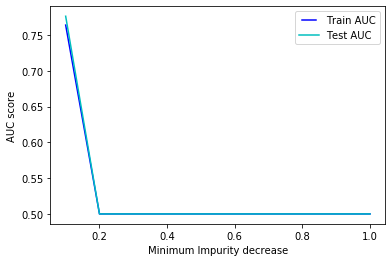

In [66]:
impurity = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []

for i in impurity:
   tree = DecisionTreeClassifier(min_impurity_decrease=i,random_state=10)
   tree.fit(X_train, y_train)
   train_pred = tree.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = tree.predict(insample_X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(insample_y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(splits, train_results,color='b', label='Train AUC')
line2, = plt.plot(splits, test_results,color='c', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Minimum Impurity decrease')
plt.show()

#### Maximum AUC is obtained at min_impurity decrease = 0

### Detemine the optimum value of  hyperparameter: class_weight

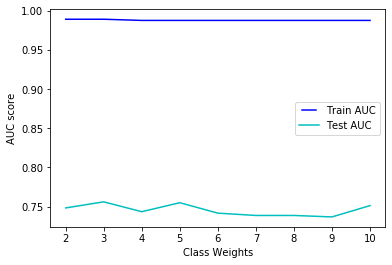

In [67]:
weights = [{0:1,1:2},{0:1,1:3},{0:1,1:4},{0:1,1:5},{0:1,1:6},{0:1,1:7},{0:1,1:8},{0:1,1:9},{0:1,1:10}]
xaxis=list(range(2,11,1))
train_results = []
test_results = []

for i in weights:
   tree = DecisionTreeClassifier(class_weight=i,random_state=10)
   tree.fit(X_train, y_train)
   train_pred = tree.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = tree.predict(insample_X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(insample_y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(xaxis, train_results,color='b', label='Train AUC')
line2, = plt.plot(xaxis, test_results,color='c', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Class Weights')
plt.show()

#### For all values of max_features, the model overfits. By default, model inspects all features to find an optimum split.

### Detemine the optimum value of  hyperparameter: ccp_alpha

- Greater values of ccp_alpha increase the number of nodes pruned.
- Nodes with the smallest effective alpha(“weakest link”) are pruned first. Min cost complexity pruning recursively finds the node
- DecisionTreeClassifier.cost_complexity_pruning_path returns the effective alphas and the corresponding total leaf impurities at each step of the pruning process.
- As alpha increases, more of the tree is pruned, which increases the total impurity of its leaves.

In [68]:
#DecisionTreeClassifier?
tree = DecisionTreeClassifier(random_state=10)
path = tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

       alpha  impurities
0   0.000000    0.013343
1   0.000000    0.013343
2   0.000140    0.013483
3   0.000193    0.013869
4   0.000468    0.014338
..       ...         ...
63  0.012728    0.268915
64  0.012736    0.281651
65  0.015489    0.297140
66  0.035858    0.332998
67  0.135752    0.468750

[68 rows x 2 columns]


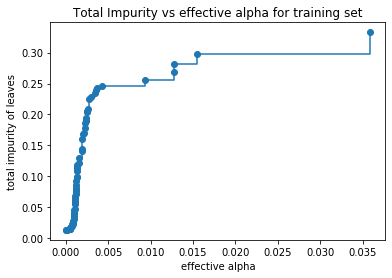

In [69]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post");
ax.set_xlabel("effective alpha");
ax.set_ylabel("total impurity of leaves");
ax.set_title("Total Impurity vs effective alpha for training set");
par=pd.DataFrame(columns=['alpha','impurities'])
par['alpha']=ccp_alphas
par['impurities']=impurities
print(par)

#### The above plot shows that as the complexity increases, the impurity of nodes increases

In [70]:
clfs = []
for ccp_alpha in ccp_alphas:
    tree = DecisionTreeClassifier(random_state=10, ccp_alpha=ccp_alpha)
    tree.fit(X_train, y_train)
    clfs.append(tree)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.13575170432198574


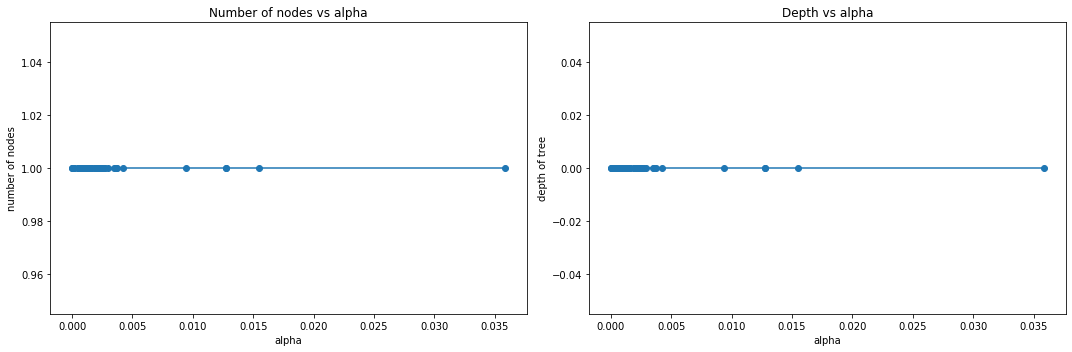

In [71]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
# remove the last element in clfs and ccp_alphas, because it is the trivial tree with only one node.

node_counts = [tree.tree_.node_count for clf in clfs]
depth = [tree.tree_.max_depth for clf in clfs]
fig, axs = plt.subplots(1, 2,figsize=(15,5))
axs[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
axs[0].set_xlabel("alpha")
axs[0].set_ylabel("number of nodes")
axs[0].set_title("Number of nodes vs alpha")
axs[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
axs[1].set_xlabel("alpha")
axs[1].set_ylabel("depth of tree")
axs[1].set_title("Depth vs alpha")
fig.tight_layout()

# Typically, the number of nodes and tree depth decreases as alpha increases.

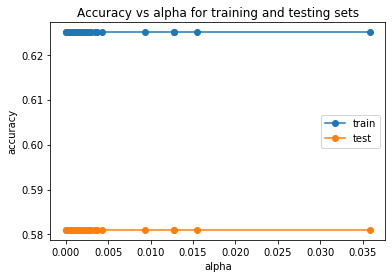

In [72]:
train_scores = [tree.score(X_train, y_train) for clf in clfs]
test_scores = [tree.score(insample_X_test, insample_y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

# Typically, as alpha increases, more of the tree is pruned, thus creating a decision tree that generalizes better.

#### Summarizing the results from above exercise, we arrive at the optimum values of hyperparameters as:
- max_depth = 12
- min_samples_split = 0.1
- min_sample_leaf = 0.1888 (0.18888888888888888)
- max_features = None
- min_impurity_decrease = 0
- class_weight = None
- ccp_alpha = None

In [74]:
ind_tree=DecisionTreeClassifier(random_state=10, max_depth=12,min_samples_split = 0.1, min_samples_leaf = 0.18888888888888888,
                            min_impurity_decrease = 0)
ind_tree.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=12, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0, min_impurity_split=None,
                       min_samples_leaf=0.18888888888888888,
                       min_samples_split=0.1, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=10, splitter='best')

In [75]:
y_pred=ind_tree.predict(insample_X_test)

In [76]:
print(accuracy_score(insample_y_test,y_pred))

false_positive_rate, true_positive_rate, thresholds = roc_curve(insample_y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

#Get recall score
print(recall_score(insample_y_test, y_pred))

0.7877094972067039
0.7764102564102564
0.7066666666666667


In [ ]:
Default model:
Accuracy = 0.776536312849162
AUC = 0.7686538461538461
recall = 0.72

Individual parameter search
Accuracy = 0.7877094972067039
AUC = 0.7764102564102564
Reacll = 0.7066666666666667

#### Accuracy and AUC increased but the recall decreased using an individual approach to select optimum values of hyperparameters

### Hyperparameter tuning using Random Search
#### Random Search does not try every combination, but selects at random to sample a wide range of values.

- n_iter (default=10): Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
- n_jobs (default=None): Number of jobs to run in parallel. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors.

In [77]:
from sklearn.model_selection import RandomizedSearchCV
import pprint

# Number of features to consider at every split
max_features = ['auto', 'sqrt','log']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 20, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,15,20,25]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,8,10,12,15,18,20]
# Method of selecting samples for training each tree
min_impurity_decrease= np.linspace(0.1, 1.0, 10, endpoint=True)
ccp_alpha=[0.001,0.0015,0.002,0.01,0.013,0.018,0]
# Create the random grid
random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'min_impurity_decrease': min_impurity_decrease,
               'ccp_alpha':ccp_alpha
               }
print(random_grid)

{'max_features': ['auto', 'sqrt', 'log'], 'max_depth': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, None], 'min_samples_split': [2, 5, 10, 15, 20, 25], 'min_samples_leaf': [1, 2, 4, 6, 8, 10, 12, 15, 18, 20], 'min_impurity_decrease': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), 'ccp_alpha': [0.001, 0.0015, 0.002, 0.01, 0.013, 0.018, 0]}


In [78]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rand_tree = DecisionTreeClassifier(random_state=10)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
tree_random = RandomizedSearchCV(estimator = rand_tree, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=10, n_jobs = -1)
# Fit the random search model
tree_random.fit(X_train, y_train)
tree_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.1s finished


{'min_samples_split': 25,
 'min_samples_leaf': 12,
 'min_impurity_decrease': 0.1,
 'max_features': 'auto',
 'max_depth': 19,
 'ccp_alpha': 0.001}

In [79]:
rand_tree=DecisionTreeClassifier(random_state=10,min_samples_split= 25, min_samples_leaf= 12, max_features='auto',min_impurity_decrease=0.1, max_depth= 19,ccp_alpha=0.001)
rand_tree.fit(X_train,y_train)
random_y_pred=rand_tree.predict(insample_X_test)

In [80]:
print(accuracy_score(insample_y_test,random_y_pred))

false_positive_rate, true_positive_rate, thresholds = roc_curve(insample_y_test, random_y_pred)
random_auc = auc(false_positive_rate, true_positive_rate)
print(random_auc)

random_recall=recall_score(insample_y_test, random_y_pred)
#Get recall score
print(random_recall)

0.7877094972067039
0.7764102564102564
0.7066666666666667


### Hyperparameter tuning using Grid Search
#### Grid Search evaluates every combination we define.

In [305]:
from sklearn.model_selection import GridSearchCV
import pprint

# Number of features to consider at every split
max_features = ['auto', 'sqrt','log']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 20, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,15,20,25]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,8,10,12,15,18,20]
# Method of selecting samples for training each tree
min_impurity_decrease= np.linspace(0.1, 1.0, 10, endpoint=True)
ccp_alpha=[0.001,0.0015,0.002,0.01,0.013,0.018,0]
# Create the random grid
grid_search = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'min_impurity_decrease': min_impurity_decrease,
               'ccp_alpha':ccp_alpha
               }
print(grid_search)

{'max_features': ['auto', 'sqrt', 'log'], 'max_depth': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, None], 'min_samples_split': [2, 5, 10, 15, 20, 25], 'min_samples_leaf': [1, 2, 4, 6, 8, 10, 12, 15, 18, 20], 'min_impurity_decrease': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), 'ccp_alpha': [0.001, 0.0015, 0.002, 0.01, 0.013, 0.018, 0]}


In [311]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
tree = DecisionTreeClassifier(random_state=10)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
tree_grid = GridSearchCV(estimator = tree, param_grid = grid_search, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
tree_grid.fit(X_train, y_train)
tree_grid.best_params_

Fitting 3 folds for each of 151200 candidates, totalling 453600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 2988 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 8266 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 15624 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 25114 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 36684 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 50386 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 66168 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 84082 tasks      | elapsed:   52.6s
[Parallel(n_jobs=-1)]: Done 104076 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 126202 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 150408 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 176746 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 205164 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Don

{'ccp_alpha': 0.001,
 'max_depth': 10,
 'max_features': 'auto',
 'min_impurity_decrease': 0.1,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [314]:
grid_tree=DecisionTreeClassifier(random_state=10,min_samples_split= 2, min_samples_leaf= 1, max_features='auto',min_impurity_decrease=0.1, max_depth= 10,ccp_alpha=0.001)
grid_tree.fit(X_train,y_train)
grid_y_pred=grid_tree.predict(insample_X_test)

In [407]:
print(accuracy_score(insample_y_test,grid_y_pred))

false_positive_rate, true_positive_rate, thresholds = roc_curve(insample_y_test, grid_y_pred)
grid_auc = auc(false_positive_rate, true_positive_rate)
print(grid_auc)

grid_recall=recall_score(insample_y_test, grid_y_pred)
#Get recall score
print(grid_recall)

0.7877094972067039
0.7764102564102564
0.7066666666666667


In [ ]:
Default model:
Accuracy = 0.776536312849162
AUC = 0.7686538461538461
recall = 0.72

Individual parameter search
Accuracy = 0.7877094972067039
AUC = 0.7764102564102564
Recall = 0.7066666666666667

Random Search
Accuracy = 0.7877094972067039
AUC = 0.7764102564102564
Recall = 0.7066666666666667

### Hyperparameter search using Bayesian Optimization

#### Bayesian Optimization terms:
#### 1) Choose the search space
Specify a range of values for hyperparameters <br>
Assumption: all the values are equally likely to occur

#### 2) Objective function
Evaluates output of hyperparamter set (Takes a set of hyperparameters, trains a classifier and returns function value) <br>
Function to be minimized <br>
Function can be accuracy score recall score

Evaluation objective function for each set can be expensive and should be restricted to minimum <br>
Surrogate and selection function make sure that the set of hyperparameters lead to decrease in objective function

#### 3) Surrogate function
It is an approximation of objective function
Variuos types = Tree Parzen Estimator (TPE), Gaussian Processes (GPyOpt), Random Forest Regression (SMAC)

#### Selection function
Applies a criterion to surrogate function for selecting a set of hyperparameters <br>
Default threshold criteria = 15 th quantile of objective function (Expected Improvement)

#### For each iteration:
1) Find the set of hyperparameter values that maximise the Expected Improvement by optimising the selection function over the surrogate function <br>
2) Hand this hyperparameter combination to the objective function for evaluation — and retrieve the corresponding score <br>
3) Update the surrogate function along the feedback of the objective function by applying Bayes’ theorem.

In [115]:
#!pip install hyperopt

In [85]:
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from time import time
from hyperopt.pyll import scope
import time

In [86]:
param_hyperopt= {
    'ccp_alpha': hp.loguniform('ccp_alpha', np.log(0.01), np.log(1)), 
    'max_features' : scope.int(hp.quniform('max_features', 0, 8, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 20, 1)),
    'min_samples_split': hp.uniform('min_samples_split', 0.0,1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.0,0.5),
    'min_impurity_decrease': hp.uniform('min_impurity_decrease', 0.0, 1.0),
}

In [87]:
def objective_function(param_hyperopt):
    tree = DecisionTreeClassifier(ccp_alpha=param_hyperopt['ccp_alpha'], 
    max_depth=param_hyperopt['max_depth'],
    min_samples_split=param_hyperopt['min_samples_split'],
    min_samples_leaf=param_hyperopt['min_samples_leaf'],
    min_impurity_decrease=param_hyperopt['min_impurity_decrease'],
    random_state=10)
    
    score = cross_val_score(tree, X_train, y_train, cv = 4, scoring='recall').mean()
    return {'loss': -score, 'status': STATUS_OK}

In [105]:
trials = Trials()
best_param = fmin(fn=objective_function, 
                      space=param_hyperopt, 
                      algo=tpe.suggest, 
                      max_evals=80, trials=trials)
    
best_param

100%|██████████| 80/80 [00:02<00:00, 39.69trial/s, best loss: -0.6742424242424242]


{'ccp_alpha': 0.023007235440280868,
 'max_depth': 7.0,
 'max_features': 7.0,
 'min_impurity_decrease': 0.002612249524674639,
 'min_samples_leaf': 0.4287570447066842,
 'min_samples_split': 0.1340983220681938}

In [108]:
tree=DecisionTreeClassifier(random_state=10,ccp_alpha= 0.03424969180604548,
 max_depth= 16,
 min_impurity_decrease=0.03170409639395788,
 min_samples_leaf= 0.14122106982565114,
 min_samples_split= 0.7549884497395987)
clf=tree.fit(X_train,y_train)
bayes_y_pred=tree.predict(insample_X_test)

In [109]:
print(accuracy_score(insample_y_test,bayes_y_pred))

false_positive_rate, true_positive_rate, thresholds = roc_curve(insample_y_test, bayes_y_pred)
bayes_auc = auc(false_positive_rate, true_positive_rate)
print(bayes_auc)

bayes_recall=recall_score(insample_y_test, bayes_y_pred)
#Get recall score
print(bayes_recall)

0.7877094972067039
0.7764102564102564
0.7066666666666667


In [110]:
import pydotplus
from IPython.display import Image
from sklearn import tree

dot_data=tree.export_graphviz(clf,out_file=None,feature_names=list(X_train.columns.values),label='all',rounded=True,filled=True,impurity=True,class_names=['0','1'])
graph=pydotplus.graph_from_dot_data(dot_data)

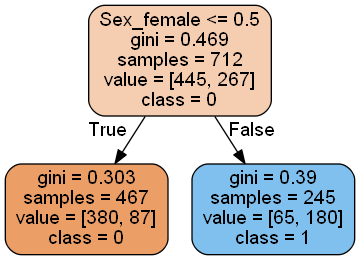

In [111]:
Image(graph.create_png())

### Characteristics of Decision Tree
- It is a nonparametric approach for building classification models. There is no prior assumptions regarding the type of probability distributions satisfied by the class and other attribute.
- computationally inexpensive,  quick construction of models for large training set.
- classifying a test record is extremely fast, with a worst-case
- complexity of O(n), where n max_depth
- large number of correlated features may cause excessive branching. Smaller number of such featires do not affect tree size.

## Naive Bayes

- Convert all categorical features to integer using Label Encoder where new labels must begin from 0 (especially for Mixed Naive Bayes)
- *Gaussian Naive Bayes* requires features to be normally distributed
- *Gaussian Naive Bayes* accepts only continuous features
- *Bernoulli Naive Bayes* accepts only binary features
- *Multinomial Naive Bayes* classifier is suitable for classification with discrete features (e.g., word counts for text classification).
- The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work
- *Complement Naive Bayes* classifier corrects “severe assumptions” made by the standard Multinomial Naive Bayes classifier. It is particularly suited for imbalanced data sets.

In [130]:
df_naive=org

from sklearn.preprocessing import LabelEncoder
# creating instance of labelencoder
le = LabelEncoder()
# Assigning numerical values and storing in another column

for i in df_naive.select_dtypes(include=['object']).columns.to_list():
    df_naive[i] = le.fit_transform(df_naive[i])
    
df_naive.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


In [23]:
df_n=df_naive[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked']]

In [133]:
X_train_n,X_test_n, y_train_n,y_test_n=train_test_split(df_naive.drop('Survived',axis=1),df_naive.Survived,test_size=0.3,random_state=100)

### Gausian Naive Bayes

In [134]:
from sklearn.naive_bayes import GaussianNB
gnb=GaussianNB()
model_naive=gnb.fit(X_train_n,y_train_n)

In [137]:
y_pred_gnb=model_naive.predict(X_test_n)

In [138]:
print(accuracy_score(y_test_n,y_pred_gnb))

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_n, y_pred_gnb)
auc_gnb = auc(false_positive_rate, true_positive_rate)
print(auc_gnb)

recall_gnb=recall_score(y_test_n, y_pred_gnb)
#Get recall score
print(recall_gnb)

0.7873134328358209
0.7745946569730541
0.7064220183486238


### Multinomial Naive Bayes

In [140]:
from sklearn.naive_bayes import MultinomialNB
mnb=MultinomialNB()
model_mnb=mnb.fit(X_train_n,y_train_n)

In [141]:
y_pred_mnb=model_mnb.predict(X_test_n)

In [142]:
print(accuracy_score(y_test_n,y_pred_mnb))

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_n, y_pred_mnb)
auc_mnb = auc(false_positive_rate, true_positive_rate)
print(auc_mnb)

recall_mnb=recall_score(y_test_n, y_pred_mnb)
#Get recall score
print(recall_mnb)

0.6902985074626866
0.6553286019271826
0.46788990825688076


### Complement Naive Bayes

In [144]:
from sklearn.naive_bayes import ComplementNB
cnb=ComplementNB()
model_cnb=cnb.fit(X_train_n,y_train_n)

In [145]:
y_pred_cnb=model_cnb.predict(X_test_n)

In [147]:
print(accuracy_score(y_test_n,y_pred_cnb))

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_n, y_pred_cnb)
auc_cnb = auc(false_positive_rate, true_positive_rate)
print(auc_cnb)

recall_cnb=recall_score(y_test_n, y_pred_cnb)
#Get recall score
print(recall_cnb)

0.6902985074626866
0.6553286019271826
0.46788990825688076


In [170]:
#!pip install mixed-naive-bayes
#X_train_n['Pclass']=X_train_n['Pclass']-1
X_test_n['Pclass']=X_test_n['Pclass']-1
X_test_n.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
205,1,0,2.0,0,1,10.4625,2
44,1,0,19.0,0,0,7.8792,1
821,1,1,27.0,0,0,8.6625,2
458,0,0,50.0,0,0,10.5000,2
795,0,1,39.0,0,0,13.0000,2


## Mixed Naive Bayes
- Option 1:
    - Transform all your data into a categorical representation by computing percentiles for each continuous variables and then binning the continuous variables using the percentiles as bin boundaries. <br>
    - For instance for the height of a person create the following bins: "very small", "small", "regular", "big", "very big" ensuring that each bin contains approximately 20% of the population of your training set. <br>
    - We don't have any utility to perform this automatically in scikit-learn but it should not be too complicated to do it yourself.
    - Now,fit a unique multinomial NB on those categorical representation of your data.
<br/><br/>
- Option 2:
    - Independently fit a gaussian NB model on the continuous part of the data and a multinomial NB model on the categorical part. <br>
    - Then transform all the dataset by taking the class assignment probabilities (with predict_proba method) as new features: np.hstack((multinomial_probas, gaussian_probas)). <br>
    - Now, refit a new model (e.g. a new gaussian NB) on the new features.
<br/><br/>
- Option 3:
    - Use Mixed Naive Bayes algorithm directly :)


In [177]:
from mixed_naive_bayes import MixedNB
mxnb=MixedNB(categorical_features=[0,1,6])
model_mxnb=mxnb.fit(X_train_n,y_train_n)

[3 2 3]


In [178]:
y_pred_mxnb=model_mxnb.predict(X_test_n)

In [175]:
print(accuracy_score(y_test_n,y_pred_mxnb))

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_n, y_pred_mxnb)
auc_mxnb = auc(false_positive_rate, true_positive_rate)
print(auc_mxnb)

recall_mxnb=recall_score(y_test_n, y_pred_mxnb)
#Get recall score
print(recall_mxnb)

0.7873134328358209
0.7673821475967919
0.6605504587155964


## Logistic Regression

In [158]:
df=pd.get_dummies(org,prefix_sep='_',drop_first=True)
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


In [159]:
X=df.drop('Survived',axis=1)
y=df.Survived

In [160]:
X_train, insample_X_test, y_train, insample_y_test = train_test_split(X,y, test_size=0.2,random_state=100)

In [168]:
from sklearn.linear_model import LogisticRegression
#create an instance and fit the model 
log_model = LogisticRegression(random_state=10)
log_model.fit(X_train, y_train)

C:\Users\pooja\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=10, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [170]:
y_pred_log=log_model.predict(insample_X_test)

print(accuracy_score(insample_y_test,y_pred_log))

false_positive_rate, true_positive_rate, thresholds = roc_curve(insample_y_test, y_pred_log)
auc_log = auc(false_positive_rate, true_positive_rate)
print(auc_log)

recall_log=recall_score(insample_y_test, y_pred_log)
#Get recall score
print(recall_log)

0.8044692737430168
0.7926923076923077
0.72


## Logistic Regression with Principal Component Analysis

__PCA limitations for mixed data (continuous + categorical):__
- PCA works well with continuous features which is easy to standardize.
- Categorical variables cannot be standardized
<br/>

__Alternatives:__
- Multiple correspondence analysis (MCA)
    - It is an extension of PCA for more than 2 categorical variables.
    - It performs one-hot encoding of dataset.
<br/>
- Multiple Factor Analysis (MFA)
    - Applies PCA on 'groups' of variables in the data
    - 3 experts give their opinion on 6 different wines. Each opinion for each wine is recorded as a variable. We thus want to consider the separate opinions of each expert whilst also having a global overview of each wine. 
<br/>
- Factor analysis of mixed data (FAMD)
    - applies PCA on mixed data (continuous + categorical)

In [254]:
X_train, insample_X_test, y_train, insample_y_test = train_test_split(org.drop('Survived',1),org[['Survived']], test_size=0.2,random_state=100)

In [205]:
#!pip install light_famd
#!pip install prince
from light_famd import FAMD
import prince

In [255]:
famd_df=pd.concat([X_train,y_train],axis=1)
famd_df

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
408,3,male,21.00000,0,0,7.7750,S,0
480,3,male,9.00000,5,2,46.9000,S,0
510,3,male,29.00000,0,0,7.7500,Q,1
609,1,female,40.00000,0,0,153.4625,S,1
547,2,male,29.87763,0,0,13.8625,C,1
...,...,...,...,...,...,...,...,...
855,3,female,18.00000,0,1,9.3500,S,1
871,1,female,47.00000,1,1,52.5542,S,1
835,1,female,39.00000,1,1,83.1583,C,1
792,3,female,25.14062,8,2,69.5500,S,0


In [263]:
famd = prince.FAMD(n_components=5)
famd.fit(famd_df.drop('Survived', axis='columns'))

FAMD(check_input=True, copy=True, engine='auto', n_components=5, n_iter=3,
     random_state=None)

In [264]:
famd.row_coordinates(famd_df)

,0,1,2,3,4
408,49.212488,-9.998672,-4.804035,-0.716794,0.303276
480,49.210033,-9.961472,-4.815123,-0.736113,3.157511
510,24.280843,-17.548796,14.525623,37.913429,-0.132445
609,32.935647,37.751074,-5.753868,-1.451064,-1.665335
547,26.132654,-17.032631,39.183940,-6.060874,0.043785
...,...,...,...,...,...
855,32.939590,37.744249,-5.792270,-1.393357,0.574770
871,32.937373,37.753711,-5.771909,-1.442405,-0.953938
835,9.857560,30.720532,38.211057,-6.769616,-0.287598
792,32.937085,37.783489,-5.802920,-1.420741,3.369079


KeyError: "None of [Index(['Embarked', 'Sex'], dtype='object')] are in the [columns]"

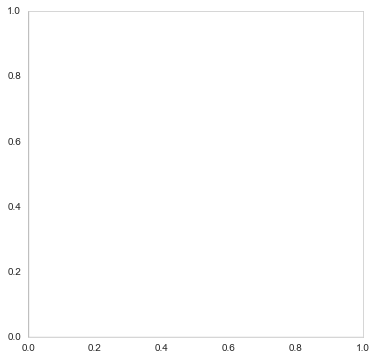

In [265]:
ax = famd.plot_row_coordinates(
X,
ax=None,
figsize=(6, 6),
x_component=0,
y_component=1,
labels=famd_df.index
#,color_labels=['Survived {}'.format(t) for t in famd_df['Survived']],
)
ax.get_figure()

In [266]:
train_famd_df = famd.transform(famd_df)

In [269]:
from sklearn.linear_model import LogisticRegression
#create an instance and fit the model 
log_pca_model = LogisticRegression(random_state=10)
log_pca_model.fit(train_famd_df, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=10, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [271]:
_famd_df=pd.concat([insample_X_test,insample_y_test],axis=1)

test_famd_df = famd.transform(_famd_df)

y_pred_log_pca=log_pca_model.predict(test_famd_df)

In [272]:
print(accuracy_score(insample_y_test,y_pred_log_pca))

false_positive_rate, true_positive_rate, thresholds = roc_curve(insample_y_test, y_pred_log_pca)
auc_log_pca = auc(false_positive_rate, true_positive_rate)
print(auc_log_pca)

recall_log_pca=recall_score(insample_y_test, y_pred_log)
#Get recall score
print(recall_log_pca)

0.7932960893854749
0.7793589743589744
0.72


### Support Vector Classifier (SVC) - Classification using SVM algorithm

In [277]:
df=pd.get_dummies(org,prefix_sep='_')
df.head()
X=df.drop('Survived',axis=1)
y=df.Survived
X_train, insample_X_test, y_train, insample_y_test = train_test_split(X,y, test_size=0.2,random_state=100)

In [299]:
from sklearn.svm import SVC # "Support Vector Classifier" 
svc = SVC(kernel='linear',random_state=10)
svc.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=10, shrinking=True, tol=0.001,
    verbose=False)

In [300]:
y_pred_svc=svc.predict(insample_X_test)

print(accuracy_score(insample_y_test,y_pred_svc))

false_positive_rate, true_positive_rate, thresholds = roc_curve(insample_y_test, y_pred_svc)
auc_svc = auc(false_positive_rate, true_positive_rate)
print(auc_svc)

recall_svc=recall_score(insample_y_test, y_pred_svc)
#Get recall score
print(recall_svc)

0.7877094972067039
0.7764102564102564
0.7066666666666667


### Random Forest

In [307]:
rf=RandomForestClassifier(random_state=100)

In [310]:
model_rf=rf.fit(X_train,y_train)
model_rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=100,
                       verbose=0, warm_start=False)

In [309]:
y_pred_rf=model_rf.predict(insample_X_test)

print(accuracy_score(insample_y_test,y_pred_rf))

false_positive_rate, true_positive_rate, thresholds = roc_curve(insample_y_test, y_pred_rf)
auc_rf = auc(false_positive_rate, true_positive_rate)
print(auc_rf)

recall_rf=recall_score(insample_y_test, y_pred_rf)
#Get recall score
print(recall_rf)

0.8268156424581006
0.8212179487179487
0.7866666666666666


### Random Forest Hyperparameter tuning: Grid Search

In [342]:
from sklearn.model_selection import GridSearchCV

n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(rf, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestfit_rf = gridF.fit(X_train, y_train)
bestfit_rf.best_params_

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  3.5min finished


{'max_depth': 8,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 800}

In [353]:
rf_grid=RandomForestClassifier(random_state=100,
max_depth= 8,
 min_samples_leaf=1,
 min_samples_split= 5,
 n_estimators= 800)

In [355]:
model_rf_grid=rf_grid.fit(X_train,y_train)

In [357]:
y_pred_rf_grid=model_rf_grid.predict(insample_X_test)

print(accuracy_score(insample_y_test,y_pred_rf_grid))

false_positive_rate, true_positive_rate, thresholds = roc_curve(insample_y_test, y_pred_rf_grid)
auc_rf_grid = auc(false_positive_rate, true_positive_rate)
print(auc_rf_grid)

recall_rf_grid=recall_score(insample_y_test, y_pred_rf_grid)
#Get recall score
print(recall_rf_grid)

0.8268156424581006
0.8212179487179487
0.7866666666666666


### Random Forest Hyperparameter tuning: Random Search

In [322]:
from sklearn.model_selection import RandomizedSearchCV
import pprint

# Number of features to consider at every split
max_features = ['auto', 'sqrt','log']

n_estimators = [100, 300, 500, 800, 1200]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 20, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,15,20,25]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,8,10,12,15,18,20]
# Method of selecting samples for training each tree
min_impurity_decrease= np.linspace(0.1, 1.0, 10, endpoint=True)
ccp_alpha=[0.001,0.0015,0.002,0.01,0.013,0.018,0]
# Create the random grid
random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'min_impurity_decrease': min_impurity_decrease,
               'ccp_alpha':ccp_alpha,
               'n_estimators':n_estimators
               }

print(random_grid)

{'max_features': ['auto', 'sqrt', 'log'], 'max_depth': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, None], 'min_samples_split': [2, 5, 10, 15, 20, 25], 'min_samples_leaf': [1, 2, 4, 6, 8, 10, 12, 15, 18, 20], 'min_impurity_decrease': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), 'ccp_alpha': [0.001, 0.0015, 0.002, 0.01, 0.013, 0.018, 0], 'n_estimators': [100, 300, 500, 800, 1200]}


In [323]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf_rand = RandomForestClassifier(random_state=100)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf_rand, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=10, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 174 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   23.5s finished


{'n_estimators': 800,
 'min_samples_split': 20,
 'min_samples_leaf': 8,
 'min_impurity_decrease': 0.1,
 'max_features': 'auto',
 'max_depth': 17,
 'ccp_alpha': 0.01}

In [369]:
rf_rand=RandomForestClassifier(random_state=100,
max_depth=17,
min_samples_leaf=8,
min_samples_split=20,
n_estimators=800,
min_impurity_decrease=0.1,
max_features='auto',
ccp_alpha=0.01)

model_rf_rand=rf_rand.fit(X_train,y_train)

In [370]:
y_pred_rf_rand=model_rf_rand.predict(insample_X_test)

print(accuracy_score(insample_y_test,y_pred_rf_rand))

false_positive_rate, true_positive_rate, thresholds = roc_curve(insample_y_test, y_pred_rf_rand)
auc_rf_rand = auc(false_positive_rate, true_positive_rate)
print(auc_rf_rand)

recall_rf_rand=recall_score(insample_y_test, y_pred_rf_rand)
#Get recall score
print(recall_rf_rand)

0.7877094972067039
0.7764102564102564
0.7066666666666667


### Bagging using Decision Tree

In [385]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

seed=10
kfold = model_selection.KFold(n_splits=10, random_state=seed)
cart = tree.DecisionTreeClassifier()
num_trees = 800
model = BaggingClassifier(base_estimator=cart, random_state=seed)
model_dt=model.fit(X_train,y_train)
#BaggingClassifier(tree.DecisionTreeClassifier(random_state=1))
results = model_selection.cross_val_score(model_dt, X_train, y_train, cv=kfold)
print(results.mean())

C:\Users\pooja\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.7894757433489827


In [386]:
y_pred_bag_dt=model_dt.predict(insample_X_test)

print(accuracy_score(insample_y_test,y_pred_bag_dt))

false_positive_rate, true_positive_rate, thresholds = roc_curve(insample_y_test, y_pred_bag_dt)
auc_bag_dt = auc(false_positive_rate, true_positive_rate)
print(auc_bag_dt)

recall_bag_dt=recall_score(insample_y_test, y_pred_bag_dt)
#Get recall score
print(recall_bag_dt)

0.7988826815642458
0.7897435897435898
0.7333333333333333


In [387]:
### AdaBoost

In [388]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier(random_state=1)
model_ada=model.fit(X_train, y_train)

In [391]:
y_pred_ada=model_ada.predict(insample_X_test)

print(accuracy_score(insample_y_test,y_pred_ada))

false_positive_rate, true_positive_rate, thresholds = roc_curve(insample_y_test, y_pred_ada)
auc_ada = auc(false_positive_rate, true_positive_rate)
print(auc_ada)

recall_ada=recall_score(insample_y_test, y_pred_ada)
#Get recall score
print(recall_ada)

0.7877094972067039
0.7801282051282051
0.7333333333333333


### XGBoost

In [397]:
#!pip install xgboost

In [395]:
import xgboost as xgb
model=xgb.XGBClassifier(random_state=1,learning_rate=0.01)
model_xgb=model.fit(X_train, y_train)

In [396]:
y_pred_xgb=model_xgb.predict(insample_X_test)

print(accuracy_score(insample_y_test,y_pred_xgb))

false_positive_rate, true_positive_rate, thresholds = roc_curve(insample_y_test, y_pred_xgb)
auc_xgb = auc(false_positive_rate, true_positive_rate)
print(auc_xgb)

recall_xgb=recall_score(insample_y_test, y_pred_xgb)
#Get recall score
print(recall_xgb)

0.8268156424581006
0.8119230769230769
0.72


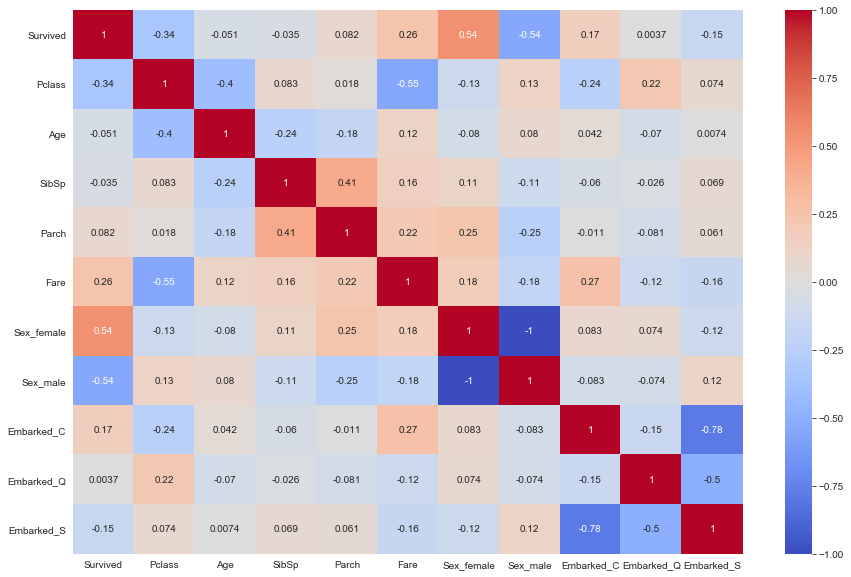

In [389]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df.corr(),annot=True,vmin=-1,vmax=1, center=0,cmap='coolwarm')
plt.show()